<a href="https://colab.research.google.com/github/H3OX/Retailhero_uplift/blob/master/uplift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
sns.set_style("darkgrid")


In [0]:
path = 'drive/My Drive/uplift/data/'
clients = pd.read_csv(path + 'clients.csv', index_col='client_id', parse_dates=['first_issue_date', 'first_redeem_date'])
products = pd.read_csv(path + 'products.csv', index_col='product_id')
purchases = pd.read_csv(path + 'purchases.csv', parse_dates=['transaction_datetime'])
train = pd.read_csv(path + 'uplift_train.csv', index_col='client_id')
test = pd.read_csv(path + 'uplift_test.csv', index_col='client_id')

In [121]:
clients.head()

,first_issue_date,first_redeem_date,age,gender
client_id,,,,
000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
000048b7a6,2018-12-15 13:33:11,NaT,68,F
000073194a,2017-05-23 12:56:14,2017-11-24 11:18:01,60,F
00007c7133,2017-05-22 16:17:08,2018-12-31 17:17:33,67,U


In [122]:
products.head()

,level_1,level_2,level_3,level_4,segment_id,brand_id,vendor_id,netto,is_own_trademark,is_alcohol
product_id,,,,,,,,,,
0003020d3c,c3d3a8e8c6,c2a3ea8d5e,b7cda0ec0c,6376f2a852,123.0,394a54a7c1,9eaff48661,0.400,0,0
0003870676,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105.0,acd3dd483f,10486c3cf0,0.680,0,0
0003ceaf69,c3d3a8e8c6,f2333c90fb,419bc5b424,f6148afbc0,271.0,f597581079,764e660dda,0.500,0,0
000701e093,ec62ce61e3,4202626fcb,88a515c084,48cf3d488f,172.0,54a90fe769,03c2d70bad,0.112,0,0
0007149564,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105.0,63417fe1f3,f329130198,0.600,0,0


## Преобразую графу даты в нормальный вид

In [0]:
purchases['date'] = purchases['transaction_datetime'].dt.date

In [124]:
purchases.head()

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red,date
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,NaN,2018-12-01
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,1.0,65.0,NaN,2018-12-01
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,1.0,24.0,NaN,2018-12-01
3,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,4055b15e4a,2.0,50.0,NaN,2018-12-01
4,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,a685f1916b,1.0,22.0,NaN,2018-12-01


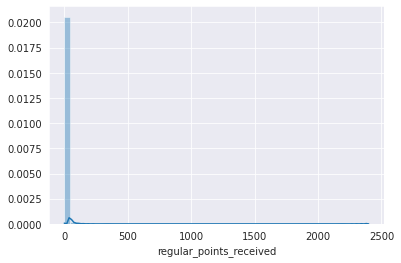

In [127]:
sns.distplot(purchases['regular_points_received'])

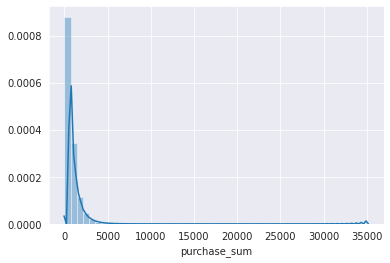

In [128]:
sns.distplot(purchases['purchase_sum'])

Сгруппирую покупки по дням

In [0]:
features = ['regular_points_received', 'express_points_received', 'regular_points_spent', 'express_points_spent', 'purchase_sum', 'product_quantity', 'store_id']
df = purchases.groupby(['client_id', 'transaction_id'])[features].first()
df_features = pd.concat([df.groupby('client_id')['purchase_sum'].count(), df.groupby('client_id').sum(), df.groupby('client_id')[['store_id']].nunique()], axis=1)
df_features.columns = ['transactions_amount', 'rpr', 'epr', 'rps', 'eps', 'psum', 'pqsum', 's_unique']

In [132]:
df_features

,transactions_amount,rpr,epr,rps,eps,psum,pqsum,s_unique
client_id,,,,,,,,
000012768d,4,25.7,0.0,0.0,0.0,2803.00,8.0,3
000036f903,32,54.9,60.0,0.0,0.0,9805.00,29.0,5
000048b7a6,8,26.5,0.0,0.0,0.0,3772.00,14.0,2
000073194a,17,74.9,0.0,-96.0,0.0,9601.40,20.0,1
00007c7133,11,56.6,0.0,-240.0,0.0,6719.84,11.0,2
...,...,...,...,...,...,...,...,...
fffece623e,24,38.4,0.0,-68.0,0.0,6530.01,23.0,3
ffff3dfff8,17,117.9,0.0,-182.0,0.0,7264.84,19.0,1
ffffaab9da,7,34.0,0.0,-6.0,0.0,3791.00,15.0,1


In [0]:
data = pd.concat([train, df_features, clients], axis=1, sort=True)

In [0]:
data['first_issue_date'] = data['first_issue_date'].dt.weekday
data['first_redeem_date'] = data['first_redeem_date'].dt.weekday
data = data[data['target'].notnull()]
data = data[data['gender'] != 'U']
data = data[data['first_redeem_date'].notnull()]

In [0]:
data['gender'].replace({
    'F': 1,
    'M': 0
}, inplace=True)
data['gender'] = data['gender'].astype(int)

In [136]:
data.head(10)

,treatment_flg,target,transactions_amount,rpr,epr,rps,eps,psum,pqsum,s_unique,first_issue_date,first_redeem_date,age,gender
000036f903,1.0,1.0,32,54.9,60.0,0.0,0.0,9805.00,29.0,5,0,6.0,72,1
0001f552b0,1.0,1.0,15,78.9,0.0,0.0,0.0,6155.18,12.0,4,4,1.0,33,1
000220a0a7,0.0,1.0,15,104.1,0.0,0.0,0.0,8606.57,26.0,5,5,3.0,115,0
00031cbbe6,0.0,1.0,29,63.7,0.0,-60.0,0.0,9266.53,26.0,3,6,6.0,48,1
0004231e2a,1.0,0.0,16,62.1,0.0,0.0,0.0,7967.00,25.0,2,3,5.0,56,1
00047b3720,1.0,0.0,35,144.0,0.0,-4.0,0.0,14841.09,39.0,3,5,5.0,53,0
00065f11c7,0.0,1.0,107,890.6,0.0,-817.0,-30.0,79920.91,231.0,2,1,4.0,31,0
0006b9ad75,1.0,1.0,16,47.6,0.0,-38.0,0.0,6651.52,17.0,2,3,1.0,61,1
00071890c8,0.0,1.0,3,14.9,0.0,0.0,0.0,1975.65,4.0,2,1,6.0,49,1
0007667c60,0.0,1.0,4,33.5,0.0,-62.0,-30.0,3338.52,4.0,1,4,5.0,46,0


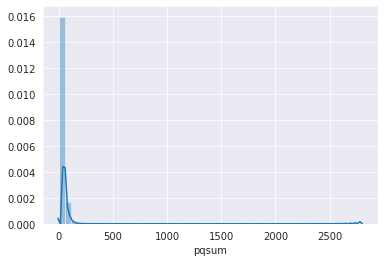

In [144]:
sns.distplot(data['pqsum'])

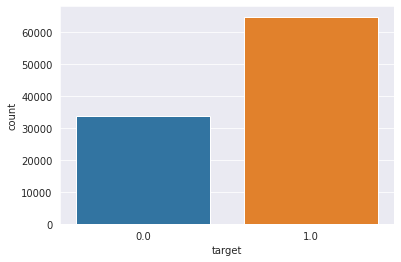

In [138]:
sns.countplot(data['target'])

Text(0.5, 1.0, 'Распределение возрастов')

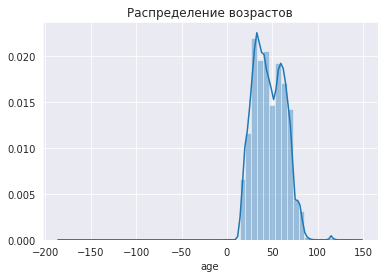

In [143]:
sns.distplot(data['age'])
plt.title('Распределение возрастов')

## Train test split

In [145]:
treatment_1 = data[data['treatment_flg'] == 1]
treatment_1.drop('treatment_flg', axis=1, inplace=True)
y = treatment_1['target']
X = treatment_1.drop('target', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
eval_set = [(X_train, y_train), (X_test, y_test)]

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [146]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

tree = DecisionTreeClassifier()
reg = LogisticRegression()
mlp = MLPClassifier()

tree.fit(X_train, y_train)
reg.fit(X_train, y_train)
mlp.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [0]:
param_grid = {
    'learning_rate': 0.03,
    'n_estimators': 100,
    'max_depth': 4,
    'subsample': 0.8,
    'gamma': 0.1,
    'colsample_bytree': 0.7
}

cv = xgb.cv(param_grid, xgb_data, num_boost_round=5000, stratified=True, metrics=['auc'])

In [148]:
cv

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.739025,0.003860,0.736034,0.005629
1,0.740292,0.002202,0.737654,0.006898
2,0.739930,0.001210,0.737105,0.007677
3,0.740634,0.001814,0.737439,0.007854
4,0.741690,0.002130,0.738396,0.007350
...,...,...,...,...
4995,0.910914,0.000699,0.721295,0.004575
4996,0.910934,0.000709,0.721284,0.004578
4997,0.910958,0.000705,0.721274,0.004578
4998,0.910980,0.000713,0.721277,0.004574


In [149]:
model = xgb.XGBClassifier(**param_grid)
model.fit(X_train, y_train, eval_metric=['auc', 'error', 'logloss'], eval_set=eval_set)

[0]	validation_0-auc:0.740863	validation_0-error:0.280031	validation_0-logloss:0.685303	validation_1-auc:0.733246	validation_1-error:0.288911	validation_1-logloss:0.685641
[1]	validation_0-auc:0.742181	validation_0-error:0.280493	validation_0-logloss:0.677981	validation_1-auc:0.735048	validation_1-error:0.292754	validation_1-logloss:0.678643
[2]	validation_0-auc:0.741649	validation_0-error:0.281505	validation_0-logloss:0.671381	validation_1-auc:0.73455	validation_1-error:0.290192	validation_1-logloss:0.672325
[3]	validation_0-auc:0.74253	validation_0-error:0.280233	validation_0-logloss:0.664826	validation_1-auc:0.735014	validation_1-error:0.289653	validation_1-logloss:0.666112
[4]	validation_0-auc:0.741943	validation_0-error:0.281013	validation_0-logloss:0.658948	validation_1-auc:0.734167	validation_1-error:0.290394	validation_1-logloss:0.66048
[5]	validation_0-auc:0.741111	validation_0-error:0.282025	validation_0-logloss:0.653367	validation_1-auc:0.733348	validation_1-error:0.291203	v

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.1,
              learning_rate=0.03, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [0]:
score = model.score(X_test, y_test)
score_tree = tree.score(X_test, y_test)
score_reg = reg.score(X_test, y_test)
score_mlp = mlp.score(X_test, y_test)

In [0]:
def plot_results(model, variable):
  results = model.evals_result()
  epochs = range(len(results['validation_0'][variable]))
  fig, ax = plt.subplots(figsize=(10, 5))
  ax.plot(epochs, results['validation_0'][variable], label='Train')
  ax.plot(epochs, results['validation_1'][variable], label='Test')
  ax.legend()

In [152]:
treatment_0 = data[data['treatment_flg'] == 0]
treatment_0.drop('treatment_flg', axis=1, inplace=True)
y = treatment_0['target']
X = treatment_0.drop('target', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
eval_set = [(X_train, y_train), (X_test, y_test)]

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [153]:
tree1 = DecisionTreeClassifier()
reg1 = LogisticRegression()
mlp1 = MLPClassifier()

tree1.fit(X_train, y_train)
reg1.fit(X_train, y_train)
mlp1.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [154]:
model1 = xgb.XGBClassifier(**param_grid)
model1.fit(X_train, y_train, eval_metric=['auc', 'error', 'logloss'], eval_set=eval_set)

[0]	validation_0-auc:0.747259	validation_0-error:0.294732	validation_0-logloss:0.686114	validation_1-auc:0.741783	validation_1-error:0.303061	validation_1-logloss:0.686302
[1]	validation_0-auc:0.738659	validation_0-error:0.300288	validation_0-logloss:0.682106	validation_1-auc:0.735976	validation_1-error:0.30469	validation_1-logloss:0.682214
[2]	validation_0-auc:0.746595	validation_0-error:0.297874	validation_0-logloss:0.675763	validation_1-auc:0.742811	validation_1-error:0.302654	validation_1-logloss:0.675997
[3]	validation_0-auc:0.749352	validation_0-error:0.295925	validation_0-logloss:0.669752	validation_1-auc:0.744772	validation_1-error:0.301772	validation_1-logloss:0.670154
[4]	validation_0-auc:0.750403	validation_0-error:0.295866	validation_0-logloss:0.664082	validation_1-auc:0.745558	validation_1-error:0.300278	validation_1-logloss:0.664605
[5]	validation_0-auc:0.750793	validation_0-error:0.295401	validation_0-logloss:0.65871	validation_1-auc:0.745885	validation_1-error:0.299667	

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.1,
              learning_rate=0.03, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [0]:
score1 = model1.score(X_test, y_test)
score_tree1 = tree1.score(X_test, y_test)
score_reg1 = reg1.score(X_test, y_test)
score_mlp1 = mlp1.score(X_test, y_test)

## Графики первой модели


## Logloss

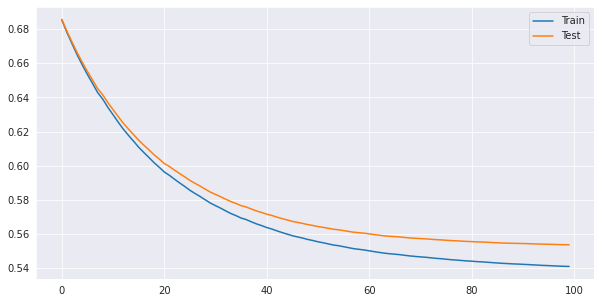

In [156]:
plot_results(model, 'logloss')

## AUC

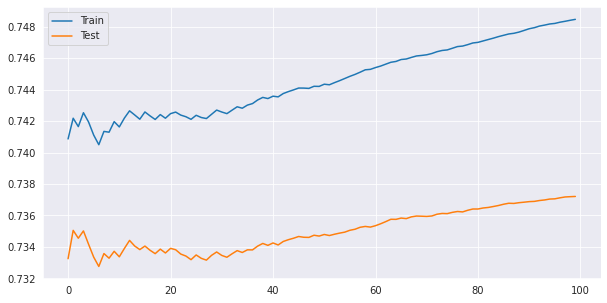

In [157]:
plot_results(model, 'auc')

## Графики второй модели


## LogLoss

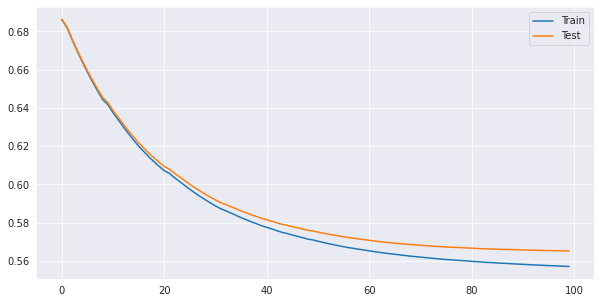

In [158]:
plot_results(model1, 'logloss')

## AUC

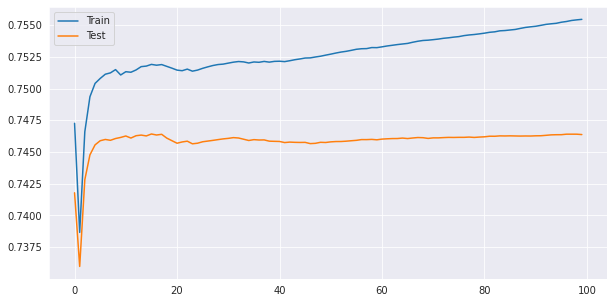

In [159]:
plot_results(model1, 'auc')

## Результаты моделей

In [160]:
pd.DataFrame({
    'XGB': [score, score1],
    'Tree': [score_tree, score_tree1],
    'LogReg': [score_reg, score_reg1],
    'MLP': [score_mlp, score_mlp1]
})

,XGB,Tree,LogReg,MLP
0,0.711560,0.619818,0.704078,0.683721
1,0.703115,0.611145,0.694631,0.696396
